In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
from collections import namedtuple

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

from Corpora import MovieReviewCorpus
from Lexicon import SentimentLexicon
from Statistics import SignTest
from Classifiers import NaiveBayesText, SVMText
from Extensions import SVMDoc2Vec
from Constants import PUNCTUATION

/Users/alanclark/.pyenv/versions/3.8.11/envs/mlmi13/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
plt.rc('font', size=20) 

In [4]:
# whether to use corpus pickles
use_pickles = False

In [5]:
plot_dir = 'plots'

# Load Corpus

In [6]:
# # retrieve corpus
# corpus_pickle = "corpus.pkl"
# if use_pickles and os.path.isfile(corpus_pickle):
#     with open(corpus_pickle, 'rb') as f:
#         corpus = pickle.load(f)
# else:
#     corpus=MovieReviewCorpus(stemming=False)
#     if os.path.isfile(corpus_pickle):
#         os.remove(corpus_pickle)
#     with open(corpus_pickle, 'wb') as f:
#         pickle.dump(corpus, f)

In [7]:
corpus_tag=MovieReviewCorpus(stemming=False)
corpus_txt=MovieReviewCorpus(stemming=False,use_txt=True)
corpus_txt_upper=MovieReviewCorpus(stemming=False,use_txt=True,lower_case=False)
corpus_txt_token=MovieReviewCorpus(stemming=False,use_txt=True,tokenise=True)

Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files
Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files
Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files
Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


# Sign Test

In [8]:
# use sign test for all significance testing
signTest=SignTest()

# Sentiment Lexicon

In [9]:
print("--- classifying reviews using sentiment lexicon  ---")

# read in lexicon
lexicon=SentimentLexicon()

--- classifying reviews using sentiment lexicon  ---


In [10]:
lexicon_df = pd.DataFrame(lexicon.lexicon).T.reset_index().rename(columns={'index': 'word', 0: 'magnitude', 1: 'polarity'})
lexicon_df

,word,magnitude,polarity
0,abandoned,weaksubj,negative
1,abandonment,weaksubj,negative
2,abandon,weaksubj,negative
3,abase,strongsubj,negative
4,abasement,strongsubj,negative
...,...,...,...
6881,zealot,strongsubj,negative
6882,zealous,strongsubj,negative
6883,zealously,strongsubj,negative
6884,zenith,strongsubj,positive


## Question 0.1

### Using the tagged reviews

In [11]:
# on average there are more positive than negative words per review (~7.13 more positive than negative per review)
# to take this bias into account will use threshold (roughly the bias itself) to make it harder to classify as positive
threshold=8

lexicon.classify(corpus_tag.reviews,threshold,magnitude=False,weak_polarity=1,strong_polarity=1)
token_preds=lexicon.predictions
print(f"token-only results: {lexicon.getAccuracy():.5f}")

lexicon.classify(corpus_tag.reviews,threshold,magnitude=True,weak_polarity=1,strong_polarity=2)
magnitude_preds=lexicon.predictions
print(f"magnitude results: {lexicon.getAccuracy():.5f}")

token-only results: 0.67900
magnitude results: 0.68250


### Using the text reviews

In [12]:
# on average there are more positive than negative words per review (~7.13 more positive than negative per review)
# to take this bias into account will use threshold (roughly the bias itself) to make it harder to classify as positive
threshold=8

lexicon.classify(corpus_txt.reviews,threshold,magnitude=False,weak_polarity=1,strong_polarity=1)
token_preds=lexicon.predictions
print(f"token-only results: {lexicon.getAccuracy():.5f}")

lexicon.classify(corpus_txt.reviews,threshold,magnitude=True,weak_polarity=1,strong_polarity=2)
magnitude_preds=lexicon.predictions
print(f"magnitude results: {lexicon.getAccuracy():.5f}")

token-only results: 0.65850
magnitude results: 0.66850


### Using the tokenised text reviews

In [13]:
# on average there are more positive than negative words per review (~7.13 more positive than negative per review)
# to take this bias into account will use threshold (roughly the bias itself) to make it harder to classify as positive
threshold=8

lexicon.classify(corpus_txt_token.reviews,threshold,magnitude=False,weak_polarity=1,strong_polarity=1)
token_preds=lexicon.predictions
print(f"token-only results: {lexicon.getAccuracy():.5f}")

lexicon.classify(corpus_txt_token.reviews,threshold,magnitude=True,weak_polarity=1,strong_polarity=2)
magnitude_preds=lexicon.predictions
print(f"magnitude results: {lexicon.getAccuracy():.5f}")

token-only results: 0.67650
magnitude results: 0.68200


### Grid Searches

#### Polarity

In [14]:
lexicon_thresholds = np.arange(-20,20)
lexicon_pol_gs_df = pd.DataFrame(lexicon_thresholds, columns=['threshold'])
def lexicon_pol_gs_func(x):
    lexicon.classify(corpus_tag.reviews,x.threshold,magnitude=False,weak_polarity=1,strong_polarity=1)
    return lexicon.getAccuracy()
lexicon_pol_gs_df['result'] = lexicon_pol_gs_df.apply(lexicon_pol_gs_func,axis=1)

In [15]:
lexicon_pol_gs_df.sort_values('result', ascending=False).head(3)

,threshold,result
31,11,0.6790
28,8,0.6790
30,10,0.6785


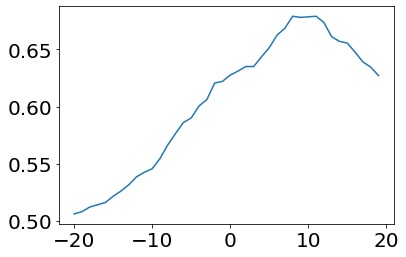

In [16]:
plt.plot(lexicon_pol_gs_df.threshold, lexicon_pol_gs_df.result)

#### Magnitude

In [17]:
lexicon_thresholds = np.arange(20)
lexicon_polarities = np.array(
    [[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [2, 5], [3 ,5]]
)
lexicon_mag_gs_df = pd.DataFrame(lexicon_thresholds, columns=['threshold']).merge(pd.DataFrame(lexicon_polarities, columns=['weak_polarity', 'strong_polarity']), how='cross')
def lexicon_mag_gs_func(x):
    lexicon.classify(corpus_tag.reviews,x.threshold,magnitude=True,weak_polarity=x.weak_polarity,strong_polarity=x.strong_polarity)
    return lexicon.getAccuracy()
lexicon_mag_gs_df['result'] = lexicon_mag_gs_df.apply(lexicon_mag_gs_func,axis=1)

In [18]:
lexicon_mag_gs_df.loc[lexicon_mag_gs_df['threshold'] == 8].sort_values('result', ascending=False).head(10)

,threshold,weak_polarity,strong_polarity,result
58,8,1,3,0.6860
60,8,1,5,0.6835
57,8,1,2,0.6825
59,8,1,4,0.6825
56,8,1,1,0.6790
61,8,2,5,0.6685
62,8,3,5,0.6545


In [19]:
lexicon_mag_gs_df.sort_values('result', ascending=False).head(10)

,threshold,weak_polarity,strong_polarity,result
99,14,1,2,0.6970
135,19,1,3,0.6965
114,16,1,3,0.6960
85,12,1,2,0.6960
92,13,1,2,0.6955
130,18,1,5,0.6950
100,14,1,3,0.6945
107,15,1,3,0.6945
123,17,1,5,0.6945
93,13,1,3,0.6945


In [20]:
lexicon_thresholds = np.arange(-20,20)
lexicon_mag_gs_1_2_df = pd.DataFrame(lexicon_thresholds, columns=['threshold'])
def lexicon_pol_gs_func(x):
    lexicon.classify(corpus_tag.reviews,x.threshold,magnitude=True,weak_polarity=1,strong_polarity=2)
    return lexicon.getAccuracy()
lexicon_mag_gs_1_2_df['result'] = lexicon_mag_gs_1_2_df.apply(lexicon_pol_gs_func,axis=1)

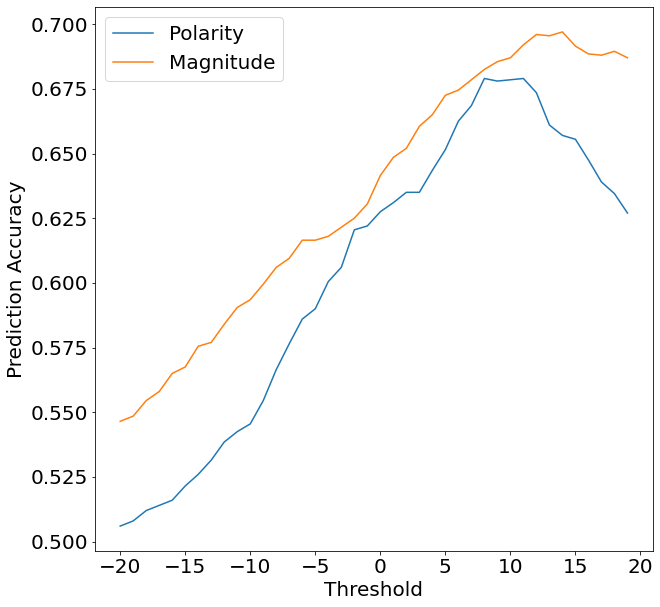

In [21]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(lexicon_pol_gs_df.threshold, lexicon_pol_gs_df.result, label='Polarity')
ax.plot(lexicon_mag_gs_1_2_df.threshold, lexicon_mag_gs_1_2_df.result, label='Magnitude')
ax.set_xlabel('Threshold')
ax.set_ylabel('Prediction Accuracy')
ax.legend()
fig.savefig(os.path.join(plot_dir, 'lexicon_thresholds.jpeg'), pad_inches=0.2, bbox_inches='tight')

## Question 0.2

In [22]:
p_value=signTest.getSignificance(token_preds,magnitude_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"magnitude lexicon results are {significance} with respect to token-only")

magnitude lexicon results are not significant with respect to token-only


# Naive Bayes

## Question 1.0

#### Using the tagged reviews

In [23]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_tag.train)
NB.test(corpus_tag.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_tag.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---


/Users/alanclark/git/MLMI13/Classifiers.py:248: RuntimeWarning: divide by zero encountered in log
  log_word_prob = np.log(word_prob)


Training accuracy without smoothing: 1.00000
Number of ties: 0
Test Accuracy without smoothing: 0.47000
Number of ties: 186


In [24]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_tag)
# store predictions from classifier
nb_tag_non_smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.47750
Std. Dev: 0.00955


#### Using uppercase text reviews

In [25]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_txt_upper.train)
NB.test(corpus_txt_upper.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_upper.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---
Training accuracy without smoothing: 1.00000
Number of ties: 0
Test Accuracy without smoothing: 0.45000
Number of ties: 198


In [26]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_upper)
# store predictions from classifier
nb_txt_upper_non_smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.45200
Std. Dev: 0.00458


#### Using the text reviews

In [27]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_txt.train)
NB.test(corpus_txt.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---
Training accuracy without smoothing: 1.00000
Number of ties: 0
Test Accuracy without smoothing: 0.45000
Number of ties: 199


In [28]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt)
# store predictions from classifier
nb_txt_non_smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.45600
Std. Dev: 0.00539


#### Using the tokenised text reviews

In [29]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_txt_token.train)
NB.test(corpus_txt_token.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_token.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---
Training accuracy without smoothing: 1.00000
Number of ties: 0
Test Accuracy without smoothing: 0.47000
Number of ties: 186


In [30]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_token)
# store predictions from classifier
nb_txt_token_non_smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.47850
Std. Dev: 0.01226


### Document and Word Probabilities

In [31]:
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_tag.train)

#### Document Prior

In [32]:
NB.prior

{'POS': 0.5, 'NEG': 0.5}

#### Word Probabilities

##### Tags

In [33]:
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_tag.train)

In [34]:
nb_word_freq = pd.DataFrame(NB.condProb).reset_index().rename(columns={'level_0': 'word'})
# nb_word_freq

In [35]:
# nb_word_freq.sort_values('POS', ascending=False).head(5)

In [36]:
# nb_word_freq.sort_values('NEG', ascending=False).head(5)

In [37]:
cloud_title = lambda x: "Positive" if x == "POS" else "Negative"

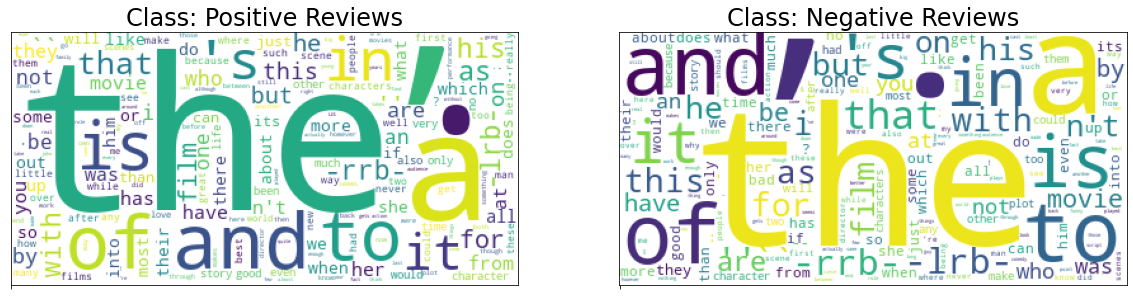

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, sent in enumerate(['POS', 'NEG']):
    nb_word_freq_top = nb_word_freq.sort_values(sent, ascending=False)
    nb_word_freq_top_dict = nb_word_freq_top[['word', sent]].set_index('word').to_dict()[sent]
    wordcloud = WordCloud(background_color='white', collocations=False).generate_from_frequencies(nb_word_freq_top_dict)
    ax[i].imshow(wordcloud)
    ax[i].set_title(f'Class: {cloud_title(sent)} Reviews')
    ax[i].set_xticks([0])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
fig.savefig(os.path.join(plot_dir, 'nb_tag_frequency_wordcloud.jpeg'), pad_inches=0.2, bbox_inches='tight')

##### Text

In [40]:
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_txt.train)
nb_word_freq = pd.DataFrame(NB.condProb).reset_index().rename(columns={'level_0': 'word'})

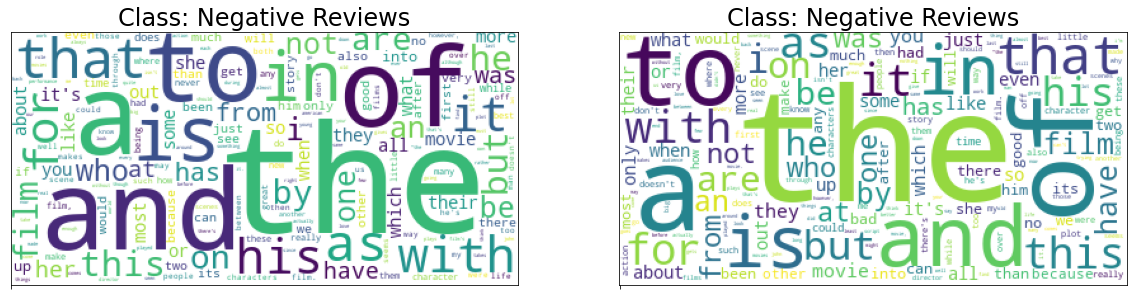

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, sent in enumerate(['POS', 'NEG']):
    nb_word_freq_top = nb_word_freq.sort_values(sent, ascending=False)
    nb_word_freq_top_dict = nb_word_freq_top[['word', sent]].set_index('word').to_dict()[sent]
    wordcloud = WordCloud(background_color='white', collocations=False).generate_from_frequencies(nb_word_freq_top_dict)
    ax[i].imshow(wordcloud)
    ax[i].set_title(f'Class: {cloud_title(sent.title())} Reviews')
    ax[i].set_xticks([0])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
fig.savefig(os.path.join(plot_dir, 'nb_txt_frequency_wordcloud.jpeg'), pad_inches=0.2, bbox_inches='tight')

##### Tokenised Text

In [42]:
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_txt_token.train)
nb_word_freq = pd.DataFrame(NB.condProb).reset_index().rename(columns={'level_0': 'word'})

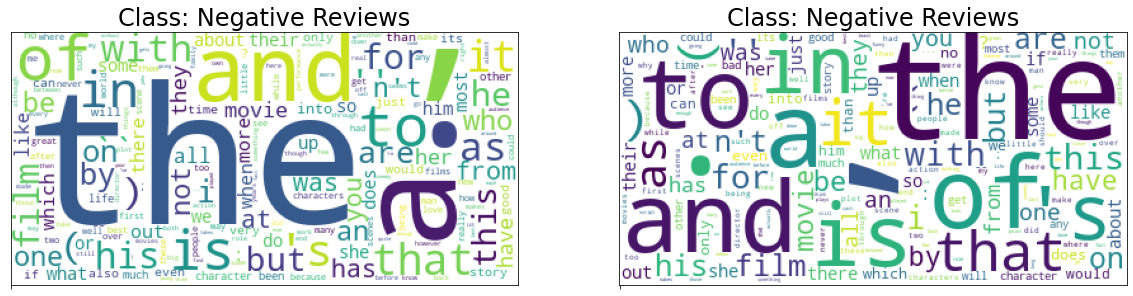

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, sent in enumerate(['POS', 'NEG']):
    nb_word_freq_top = nb_word_freq.sort_values(sent, ascending=False)
    nb_word_freq_top_dict = nb_word_freq_top[['word', sent]].set_index('word').to_dict()[sent]
    wordcloud = WordCloud(background_color='white', collocations=False).generate_from_frequencies(nb_word_freq_top_dict)
    ax[i].imshow(wordcloud)
    ax[i].set_title(f'Class: {cloud_title(sent.title())} Reviews')
    ax[i].set_xticks([0])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
fig.savefig(os.path.join(plot_dir, 'nb_txt_token_frequency_wordcloud.jpeg'), pad_inches=0.2, bbox_inches='tight')

### Exclude punctuation

In [44]:
nb_word_freq_punct = nb_word_freq.loc[~nb_word_freq['word'].isin(PUNCTUATION)]
nb_word_freq_punct

,word,POS,NEG
0,deluded,0.000003,0.000002
1,ozone,0.000000,0.000002
2,u-bar,0.000000,0.000003
3,stansfield,0.000000,0.000003
4,differentiation,0.000001,0.000000
...,...,...,...
45969,seeks,0.000015,0.000011
45970,stringent,0.000001,0.000000
45971,jérémie,0.000001,0.000000
45972,madio,0.000000,0.000003


In [45]:
nb_word_freq_punct.sort_values('POS', ascending=False).head(5)

,word,POS,NEG
36055,the,0.051535,0.048512
18119,a,0.025086,0.024723
32368,and,0.024614,0.021665
31987,of,0.023160,0.021416
11934,to,0.020474,0.021368


In [46]:
nb_word_freq_punct.sort_values('NEG', ascending=False).head(5)

,word,POS,NEG
36055,the,0.051535,0.048512
18119,a,0.025086,0.024723
32368,and,0.024614,0.021665
31987,of,0.023160,0.021416
11934,to,0.020474,0.021368


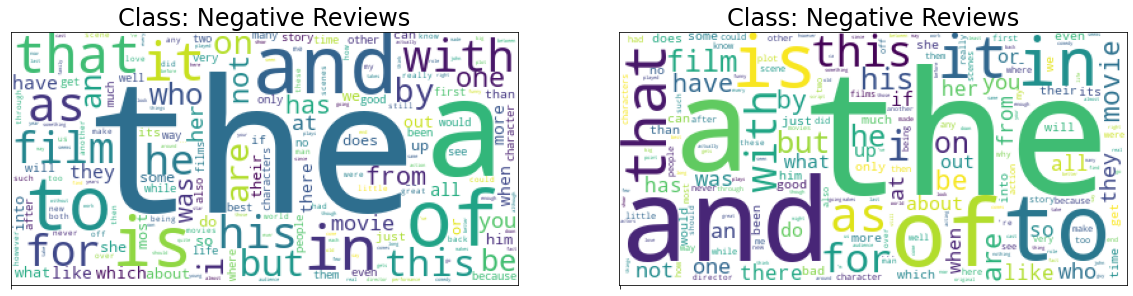

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, sent in enumerate(['POS', 'NEG']):
    nb_word_freq_top = nb_word_freq_punct.sort_values(sent, ascending=False)
    nb_word_freq_top_dict = nb_word_freq_top[['word', sent]].set_index('word').to_dict()[sent]
    wordcloud = WordCloud(background_color='white', collocations=False).generate_from_frequencies(nb_word_freq_top_dict)
    ax[i].imshow(wordcloud)
    ax[i].set_title(f'Class: {cloud_title(sent.title())} Reviews')
    ax[i].set_xticks([0])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
fig.savefig(os.path.join(plot_dir, 'nb_frequency_punct_wordcloud.jpeg'), pad_inches=0.2, bbox_inches='tight')

In [48]:
corpus_txt_token_punct=MovieReviewCorpus(stemming=False,use_txt=True,allowed_vocab=set(nb_word_freq_punct['word'].unique()))

Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [49]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_txt_token_punct.train)
NB.test(corpus_txt_token_punct.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_token_punct.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---


/Users/alanclark/git/MLMI13/Classifiers.py:248: RuntimeWarning: divide by zero encountered in log
  log_word_prob = np.log(word_prob)


Training accuracy without smoothing: 1.00000
Number of ties: 0
Test Accuracy without smoothing: 0.48000
Number of ties: 186


In [50]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_token_punct)
# store predictions from classifier
nb_txt_token_punct_non_smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.48200
Std. Dev: 0.01887


### Exclude stopwords

In [51]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alanclark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
nb_word_freq_stop = nb_word_freq.loc[~nb_word_freq['word'].isin(stopwords.words('english'))]

In [53]:
nb_word_freq_stop.sort_values('POS', ascending=False).head(5)

,word,POS,NEG
4077,",",0.053335,0.049281
32286,.,0.038536,0.039808
2609,'s,0.011820,0.012094
32907,),0.007564,0.008079
39715,(,0.007529,0.007948


In [54]:
nb_word_freq_stop.sort_values('NEG', ascending=False).head(5)

,word,POS,NEG
4077,",",0.053335,0.049281
32286,.,0.038536,0.039808
2609,'s,0.011820,0.012094
32907,),0.007564,0.008079
39715,(,0.007529,0.007948


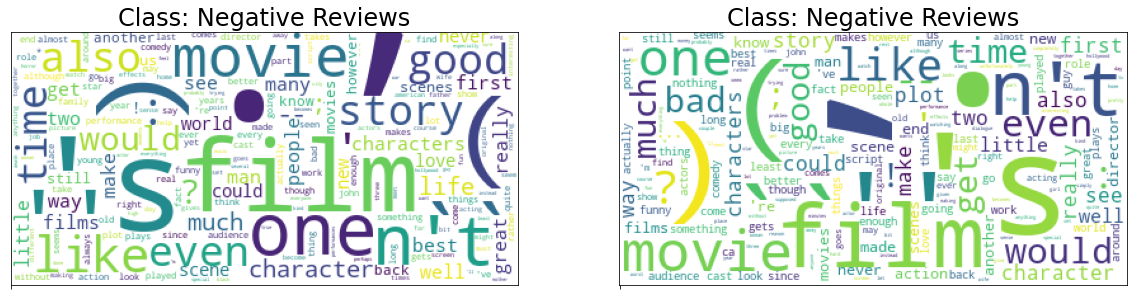

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, sent in enumerate(['POS', 'NEG']):
    nb_word_freq_top = nb_word_freq_stop.sort_values(sent, ascending=False)
    nb_word_freq_top_dict = nb_word_freq_top[['word', sent]].set_index('word').to_dict()[sent]
    wordcloud = WordCloud(background_color='white', collocations=False).generate_from_frequencies(nb_word_freq_top_dict)
    ax[i].imshow(wordcloud)
    ax[i].set_title(f'Class: {cloud_title(sent.title())} Reviews')
    ax[i].set_xticks([0])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
fig.savefig(os.path.join(plot_dir, 'nb_frequency_stop_wordcloud.jpeg'), pad_inches=0.2, bbox_inches='tight')

In [56]:
corpus_txt_token_stop=MovieReviewCorpus(stemming=False,use_txt=True,tokenise=True,allowed_vocab=set(nb_word_freq_stop['word'].unique()))

Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [57]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_txt_token_stop.train)
NB.test(corpus_txt_token_stop.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_token_stop.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---


/Users/alanclark/git/MLMI13/Classifiers.py:248: RuntimeWarning: divide by zero encountered in log
  log_word_prob = np.log(word_prob)


Training accuracy without smoothing: 1.00000
Number of ties: 0
Test Accuracy without smoothing: 0.47000
Number of ties: 186


In [58]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_token_stop)
# store predictions from classifier
nb_txt_token_stop_non_smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.47850
Std. Dev: 0.01226


### Exclude stopwords and punctuation

In [59]:
nb_word_freq_stop_punct = nb_word_freq.loc[~((nb_word_freq['word'].isin(stopwords.words('english'))) | (nb_word_freq['word'].isin(PUNCTUATION)))]

In [60]:
nb_word_freq_stop_punct.sort_values('POS', ascending=False).head(5)

,word,POS,NEG
15246,film,0.006494,0.005957
38606,one,0.003685,0.003624
6596,movie,0.003105,0.004405
29701,like,0.002159,0.002547
41940,story,0.001535,0.001263


In [61]:
nb_word_freq_stop_punct.sort_values('NEG', ascending=False).head(5)

,word,POS,NEG
15246,film,0.006494,0.005957
6596,movie,0.003105,0.004405
38606,one,0.003685,0.003624
29701,like,0.002159,0.002547
6348,even,0.001457,0.001894


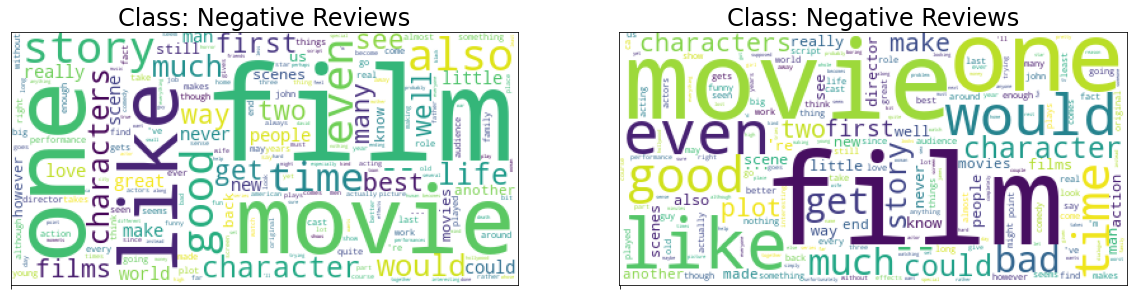

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, sent in enumerate(['POS', 'NEG']):
    nb_word_freq_top = nb_word_freq_stop_punct.sort_values(sent, ascending=False)
    nb_word_freq_top_dict = nb_word_freq_top[['word', sent]].set_index('word').to_dict()[sent]
    wordcloud = WordCloud(background_color='white', collocations=False).generate_from_frequencies(nb_word_freq_top_dict)
    ax[i].imshow(wordcloud)
    ax[i].set_title(f'Class: {cloud_title(sent.title())} Reviews')
    ax[i].set_xticks([0])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
fig.savefig(os.path.join(plot_dir, 'nb_frequency_stop_punct_wordcloud.jpeg'), pad_inches=0.2, bbox_inches='tight')

In [63]:
corpus_txt_token_stop_punct=MovieReviewCorpus(stemming=False,use_txt=True,tokenise=True,allowed_vocab=set(nb_word_freq_stop_punct['word'].unique()))

Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [64]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_txt_token_stop_punct.train)
NB.test(corpus_txt_token_stop_punct.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_token_stop_punct.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---


/Users/alanclark/git/MLMI13/Classifiers.py:248: RuntimeWarning: divide by zero encountered in log
  log_word_prob = np.log(word_prob)


Training accuracy without smoothing: 1.00000
Number of ties: 0
Test Accuracy without smoothing: 0.47000
Number of ties: 186


In [65]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_token_stop_punct)
# store predictions from classifier
nb_txt_token_stop_punct_non_smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.47850
Std. Dev: 0.01226


### Exclude words not in Lexicon

In [66]:
nb_word_freq_lexicon = lexicon_df.set_index('word').join(nb_word_freq.set_index('word'), how='left').reset_index()
nb_word_freq_lexicon

,word,magnitude,polarity,POS,NEG
0,abandoned,weaksubj,negative,0.000029,0.000030
1,abandonment,weaksubj,negative,0.000003,0.000003
2,abandon,weaksubj,negative,0.000022,0.000012
3,abase,strongsubj,negative,NaN,NaN
4,abasement,strongsubj,negative,NaN,NaN
...,...,...,...,...,...
6881,zealot,strongsubj,negative,0.000001,0.000000
6882,zealous,strongsubj,negative,0.000000,0.000002
6883,zealously,strongsubj,negative,0.000001,0.000002
6884,zenith,strongsubj,positive,0.000001,0.000002


In [67]:
nb_word_freq_lexicon.loc[nb_word_freq_lexicon['polarity'] == 'positive'].sort_values('POS', ascending=False).head(5)

,word,magnitude,polarity,POS,NEG
3920,like,strongsubj,positive,0.002159,0.002547
3770,just,weaksubj,positive,0.001668,0.002147
6797,will,strongsubj,positive,0.001625,0.001291
2742,good,weaksubj,positive,0.001479,0.001547
2154,even,weaksubj,positive,0.001457,0.001894


In [68]:
nb_word_freq_lexicon.loc[nb_word_freq_lexicon['polarity'] == 'negative'].sort_values('NEG', ascending=False).head(5)

,word,magnitude,polarity,POS,NEG
514,bad,strongsubj,negative,0.000450,0.001435
4762,plot,strongsubj,negative,0.000686,0.001179
6222,too,weaksubj,negative,0.000920,0.001141
3934,little,strongsubj,negative,0.000942,0.001018
1851,down,weaksubj,negative,0.000549,0.000600


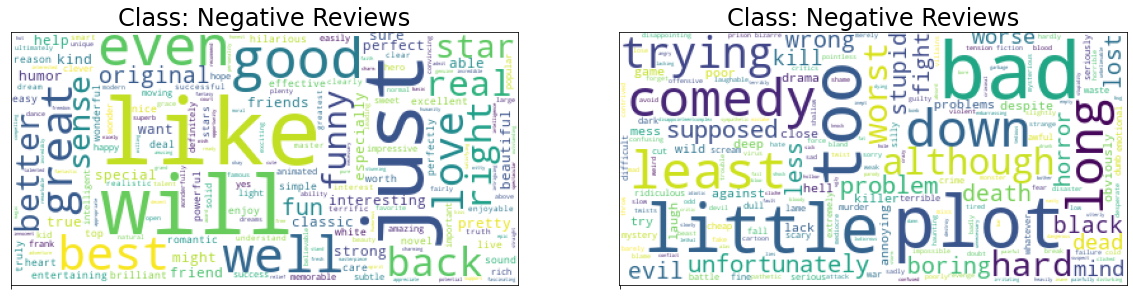

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, sent in enumerate([('POS', 'positive'), ('NEG', 'negative')]):
    nb_word_freq_top = nb_word_freq_lexicon.loc[nb_word_freq_lexicon['polarity'] == sent[1]].sort_values(sent[0], ascending=False)
    nb_word_freq_top_dict = nb_word_freq_top[['word', sent[0]]].set_index('word').to_dict()[sent[0]]
    wordcloud = WordCloud(background_color='white', collocations=False).generate_from_frequencies(nb_word_freq_top_dict)
    ax[i].imshow(wordcloud)
    ax[i].set_title(f'Class: {cloud_title(sent)} Reviews')
    ax[i].set_xticks([0])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
fig.savefig(os.path.join(plot_dir, 'nb_frequency_lexicon_wordcloud.jpeg'), pad_inches=0.2, bbox_inches='tight')

In [71]:
corpus_txt_token_lexicon=MovieReviewCorpus(stemming=False,use_txt=True,tokenise=True,allowed_vocab=set(lexicon_df['word'].unique()))

Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [72]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_txt_token_lexicon.train)
NB.test(corpus_txt_token_lexicon.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_token_lexicon.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---


/Users/alanclark/git/MLMI13/Classifiers.py:248: RuntimeWarning: divide by zero encountered in log
  log_word_prob = np.log(word_prob)


Training accuracy without smoothing: 0.96111
Number of ties: 0
Test Accuracy without smoothing: 0.68000
Number of ties: 53


In [73]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_token_lexicon)
# store predictions from classifier
nb_txt_token_lexicon_non_smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.66150
Std. Dev: 0.03210


In [74]:
# see if limiting the vocabulary to the lexicon significantly improves results
p_value=signTest.getSignificance(nb_txt_token_non_smoothed_preds,nb_txt_token_lexicon_non_smoothed_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results limiting the vocabulary to the lexicon are {significance} with respect to not doing so")

results limiting the vocabulary to the lexicon are significant with respect to not doing so


### Only allow words that are in the lexicon with positive or negative polarity

In [75]:
corpus_txt_token_lexicon_pol=MovieReviewCorpus(stemming=False,use_txt=True,tokenise=True,allowed_vocab=set(lexicon_df.loc[lexicon_df['polarity'].isin(['negative', 'positive'])]['word'].unique()))

Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [76]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_txt_token_lexicon_pol.train)
NB.test(corpus_txt_token_lexicon_pol.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_token_lexicon_pol.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---
Training accuracy without smoothing: 0.96111
Number of ties: 0
Test Accuracy without smoothing: 0.69500
Number of ties: 47


In [77]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_token_lexicon_pol)
# store predictions from classifier
nb_txt_token_lexicon_pol_non_smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.65900
Std. Dev: 0.03639


## Question 2.0

#### Using the tagged reviews

In [78]:
# use smoothing
laplacian_k = 1
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
NB.train(corpus_tag.train)
NB.test(corpus_tag.train, verbose=False)
print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_tag.test, verbose=False)
print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

Training Accuracy using smoothing with laplacian 1: 0.97444
Number of ties: 0
Test Accuracy using smoothing with laplacian 1: 0.82500
Number of ties: 0


In [79]:
print("--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_tag)
print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---
Accuracy with laplacian 1: 0.81700
Std. Dev with laplacian 1: 0.02581


#### Using uppercase text reviews

In [80]:
# use smoothing
laplacian_k = 1
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
NB.train(corpus_txt_upper.train)
NB.test(corpus_txt_upper.train, verbose=False)
print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_upper.test, verbose=False)
print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

Training Accuracy using smoothing with laplacian 1: 0.99667
Number of ties: 0
Test Accuracy using smoothing with laplacian 1: 0.85000
Number of ties: 0


In [81]:
print("--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_upper)
print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---
Accuracy with laplacian 1: 0.81650
Std. Dev with laplacian 1: 0.02470


#### Using the text reviews

In [82]:
# use smoothing
laplacian_k = 1
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
NB.train(corpus_txt.train)
NB.test(corpus_txt.train, verbose=False)
print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt.test, verbose=False)
print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

Training Accuracy using smoothing with laplacian 1: 0.99667
Number of ties: 0
Test Accuracy using smoothing with laplacian 1: 0.85000
Number of ties: 0


In [83]:
print("--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt)
print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---
Accuracy with laplacian 1: 0.82550
Std. Dev with laplacian 1: 0.02797


#### Using the tokenised text reviews

In [103]:
# use smoothing
laplacian_k = 1
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
NB.train(corpus_txt_token.train)
NB.test(corpus_txt_token.train, verbose=False)
print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_token.test, verbose=False)
print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

Training Accuracy using smoothing with laplacian 1: 0.97611
Number of ties: 0
Test Accuracy using smoothing with laplacian 1: 0.82500
Number of ties: 0


In [104]:
print("--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_token)
nb_smoothed_txt_token_preds = NB.predictions
print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---
Accuracy with laplacian 1: 0.81800
Std. Dev with laplacian 1: 0.02676


#### Using the tokenised stop word text reviews

In [86]:
# use smoothing
laplacian_k = 1
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
NB.train(corpus_txt_token_stop.train)
NB.test(corpus_txt_token_stop.train, verbose=False)
print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_token_stop.test, verbose=False)
print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

Training Accuracy using smoothing with laplacian 1: 0.98333
Number of ties: 0
Test Accuracy using smoothing with laplacian 1: 0.82500
Number of ties: 0


In [87]:
print("--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_token_stop)
print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---
Accuracy with laplacian 1: 0.81900
Std. Dev with laplacian 1: 0.02800


#### Using the tokenised stop punct text reviews

In [88]:
# use smoothing
laplacian_k = 1
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
NB.train(corpus_txt_token_stop_punct.train)
NB.test(corpus_txt_token_stop_punct.train, verbose=False)
print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_token_stop_punct.test, verbose=False)
print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

Training Accuracy using smoothing with laplacian 1: 0.98556
Number of ties: 0
Test Accuracy using smoothing with laplacian 1: 0.82000
Number of ties: 0


In [89]:
print("--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_token_stop_punct)
print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---
Accuracy with laplacian 1: 0.81750
Std. Dev with laplacian 1: 0.02648


#### Using the tokenised text lexicon reviews

In [90]:
# use smoothing
laplacian_k = 1
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
NB.train(corpus_txt_token_lexicon.train)
NB.test(corpus_txt_token_lexicon.train, verbose=False)
print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_token.test, verbose=False)
print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

Training Accuracy using smoothing with laplacian 1: 0.92833
Number of ties: 0
Test Accuracy using smoothing with laplacian 1: 0.85500
Number of ties: 0


In [91]:
print("--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_token_lexicon)
print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---
Accuracy with laplacian 1: 0.82750
Std. Dev with laplacian 1: 0.01806


#### Using the tokenised pos/neg text lexicon reviews

In [92]:
# use smoothing
laplacian_k = 1
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
NB.train(corpus_txt_token_lexicon_pol.train)
NB.test(corpus_txt_token_lexicon_pol.train, verbose=False)
print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_token.test, verbose=False)
print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

Training Accuracy using smoothing with laplacian 1: 0.92667
Number of ties: 0
Test Accuracy using smoothing with laplacian 1: 0.83500
Number of ties: 0


In [93]:
print("--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_token_lexicon_pol)
print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---
Accuracy with laplacian 1: 0.82950
Std. Dev with laplacian 1: 0.01540


## Question 3.0
Moved this part up so that I could use the predictions from cross-evaluation on Q2.1

In [95]:
# print("--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---")
# # using previous instantiated object
# NB.crossValidate(corpus)
# print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
# print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

### Smoothing Grid Search

In [96]:
def nb_extract_frequencies(cond_prod):
    df = pd.DataFrame(cond_prod).reset_index().rename(columns={'level_0': 'word'}).sort_values('word')
    return np.array(df['word']), np.array(df['POS']), np.array(df['NEG'])

In [97]:
nb_laplace_smoothing_vals_large = np.arange(0.1,10,0.1)
nb_laplace_smoothing_test_accuracies = np.zeros_like(nb_laplace_smoothing_vals_large)
for i, laplace_smoothing in tqdm(enumerate(nb_laplace_smoothing_vals_large)):
    NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False,laplacian_k=laplace_smoothing)
    NB.train(corpus_txt_token.train)
    NB.test(corpus_txt_token.test, verbose=False)
    words, _, _ = nb_extract_frequencies(NB.condProb)
    nb_laplace_smoothing_test_accuracies[i] = NB.getAccuracy()
nb_laplace_smoothing_test_accuracies

99it [03:31,  2.14s/it]


array([0.815, 0.825, 0.83 , 0.825, 0.825, 0.825, 0.825, 0.825, 0.825,
       0.825, 0.825, 0.825, 0.825, 0.825, 0.83 , 0.83 , 0.825, 0.825,
       0.825, 0.825, 0.83 , 0.83 , 0.83 , 0.835, 0.835, 0.835, 0.83 ,
       0.83 , 0.835, 0.83 , 0.83 , 0.83 , 0.84 , 0.84 , 0.845, 0.85 ,
       0.845, 0.84 , 0.84 , 0.83 , 0.83 , 0.83 , 0.825, 0.825, 0.82 ,
       0.82 , 0.82 , 0.815, 0.815, 0.82 , 0.815, 0.82 , 0.825, 0.825,
       0.82 , 0.82 , 0.815, 0.815, 0.815, 0.815, 0.815, 0.805, 0.805,
       0.8  , 0.795, 0.795, 0.795, 0.795, 0.795, 0.79 , 0.79 , 0.785,
       0.78 , 0.78 , 0.77 , 0.77 , 0.77 , 0.765, 0.765, 0.765, 0.765,
       0.76 , 0.76 , 0.76 , 0.76 , 0.76 , 0.76 , 0.76 , 0.755, 0.755,
       0.755, 0.755, 0.75 , 0.75 , 0.75 , 0.75 , 0.75 , 0.745, 0.745])

In [98]:
nb_laplace_smoothing_vals_large[np.argmax(nb_laplace_smoothing_test_accuracies)]

3.6

In [99]:
nb_laplace_smoothing_vals = [0, 0.1, 1, 10]
nb_laplace_smoothing_pos_frequencies = np.zeros((len(nb_laplace_smoothing_vals), 45974))
nb_laplace_smoothing_neg_frequencies = np.zeros((len(nb_laplace_smoothing_vals), 45974))
for i, laplace_smoothing in tqdm(enumerate(nb_laplace_smoothing_vals)):
    NB=NaiveBayesText(smoothing=laplace_smoothing > 0,bigrams=False,trigrams=False,discard_closed_class=False,laplacian_k=laplace_smoothing)
    NB.train(corpus_txt_token.train)
    NB.test(corpus_txt_token.test, verbose=False)
    words, pos_freq, neg_freq = nb_extract_frequencies(NB.condProb)

    nb_laplace_smoothing_pos_frequencies[i,:] = pos_freq
    nb_laplace_smoothing_neg_frequencies[i,:] = neg_freq

4it [00:07,  1.95s/it]


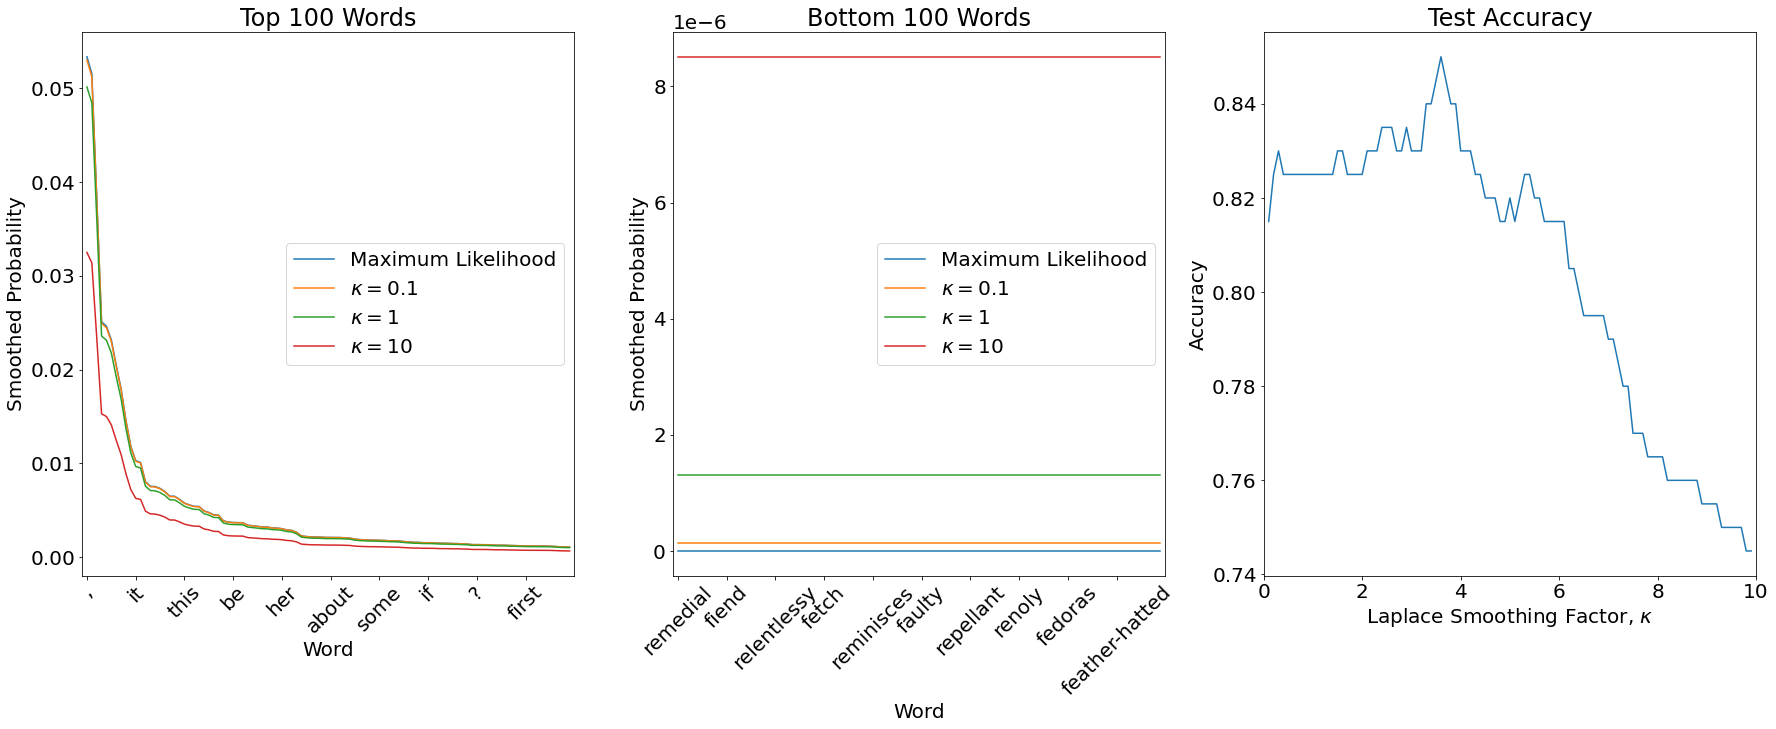

In [100]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

nb_laplace_smoothing_pos_frequencies_argsort = np.argsort(-nb_laplace_smoothing_pos_frequencies[0,:])

ax[0].plot(nb_laplace_smoothing_pos_frequencies[:, nb_laplace_smoothing_pos_frequencies_argsort[:100]].T)
ax[0].set_title("Top 100 Words")
ax[0].set_xlabel("Word")
ax[0].set_ylabel("Smoothed Probability")
ax[0].set_xticks(np.arange(0,100,10))
ax[0].set_xlim(-1,100)
ax[0].set_xticklabels(words[nb_laplace_smoothing_pos_frequencies_argsort[0:100:10]], rotation=45)
ax[0].legend(['Maximum Likelihood', r'$\kappa=0.1$', r'$\kappa=1$', r'$\kappa=10$'], loc='center right')

ax[1].plot(nb_laplace_smoothing_pos_frequencies[:, nb_laplace_smoothing_pos_frequencies_argsort[-100:]].T)
ax[1].set_title("Bottom 100 Words")
ax[1].set_xlabel("Word")
ax[1].set_ylabel("Smoothed Probability")
ax[1].set_xticks(np.arange(0,100,10))
ax[1].set_xlim(-1,100)
ax[1].set_xticklabels(words[nb_laplace_smoothing_pos_frequencies_argsort[-100::10]], rotation=45)
ax[1].legend(['Maximum Likelihood', r'$\kappa=0.1$', r'$\kappa=1$', r'$\kappa=10$'], loc='center right')

ax[2].plot(nb_laplace_smoothing_vals_large, nb_laplace_smoothing_test_accuracies)
ax[2].set_title("Test Accuracy")
ax[2].set_xlabel(r'Laplace Smoothing Factor, $\kappa$')
ax[2].set_ylabel("Accuracy")
ax[2].set_xlim(0,10)

fig.savefig(os.path.join(plot_dir, 'nb_smoothed_word_probabilities.jpeg'), pad_inches=0.2, bbox_inches='tight')

In [101]:
# use smoothing
laplacian_k = 3.6
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
NB.train(corpus_txt_token.train)
NB.test(corpus_txt_token.train, verbose=False)
print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_token.test, verbose=False)
print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

Training Accuracy using smoothing with laplacian 3.6: 0.96444
Number of ties: 0
Test Accuracy using smoothing with laplacian 3.6: 0.85000
Number of ties: 0


In [102]:
print("--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_txt_token)
# saving this for use later
num_non_stemmed_features=len(NB.vocabulary)
# using cross-eval for smoothed predictions from now on
nb_smoothed_txt_token_optimised_preds=NB.predictions
print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---
Accuracy with laplacian 3.6: 0.82100
Std. Dev with laplacian 3.6: 0.02508


In [105]:
# see if hyperparameter tuning significantly improves results
p_value=signTest.getSignificance(nb_smoothed_txt_token_preds,nb_smoothed_txt_token_optimised_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using tuned hyperparameters are {significance} with respect to defaults")

results using tuned hyperparameters are not significant with respect to defaults


### Look at other corpora

In [ ]:
# laplacian_k_vals = [0.1, 1, 2, 3, 4, 5]

#### Remove punctuation

In [ ]:
# nb_smoothed_test_accuracies = np.zeros(len(laplacian_k_vals))
# for i, laplacian_k in enumerate(laplacian_k_vals):
#     NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
#     NB.train(corpus_punct.train)
#     NB.test(corpus_punct.test, verbose=False)
#     nb_smoothed_test_accuracies[i] = NB.getAccuracy()

# laplacian_k = laplacian_k_vals[np.argmax(nb_smoothed_test_accuracies)]

# NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
# NB.train(corpus_punct.train)
# NB.test(corpus_punct.train, verbose=False)
# print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
# print(f"Number of ties: {NB.ties}")
# NB.test(corpus_punct.test, verbose=False)
# print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
# print(f"Number of ties: {NB.ties}")
# NB.crossValidate(corpus_punct)
# print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
# print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

Training Accuracy using smoothing with laplacian 2: 0.96611
Number of ties: 0
Test Accuracy using smoothing with laplacian 2: 0.83500
Number of ties: 0
Accuracy with laplacian 2: 0.83000
Std. Dev with laplacian 2: 0.06403


#### Remove stop words

In [ ]:
# nb_smoothed_test_accuracies = np.zeros(len(laplacian_k_vals))
# for i, laplacian_k in enumerate(laplacian_k_vals):
#     NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
#     NB.train(corpus_stop.train)
#     NB.test(corpus_stop.test, verbose=False)
#     nb_smoothed_test_accuracies[i] = NB.getAccuracy()

# laplacian_k = laplacian_k_vals[np.argmax(nb_smoothed_test_accuracies)]

# NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
# NB.train(corpus_stop.train)
# NB.test(corpus_stop.train, verbose=False)
# print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
# print(f"Number of ties: {NB.ties}")
# NB.test(corpus_stop.test, verbose=False)
# print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
# print(f"Number of ties: {NB.ties}")
# NB.crossValidate(corpus_stop)
# print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
# print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

Training Accuracy using smoothing with laplacian 4: 0.96556
Number of ties: 0
Test Accuracy using smoothing with laplacian 4: 0.84000
Number of ties: 0
Accuracy with laplacian 4: 0.84000
Std. Dev with laplacian 4: 0.06633


#### Remove stop words and punctuation

In [ ]:
# nb_smoothed_test_accuracies = np.zeros(len(laplacian_k_vals))
# for i, laplacian_k in enumerate(laplacian_k_vals):
#     NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
#     NB.train(corpus_stop_punct.train)
#     NB.test(corpus_stop_punct.test, verbose=False)
#     nb_smoothed_test_accuracies[i] = NB.getAccuracy()

# laplacian_k = laplacian_k_vals[np.argmax(nb_smoothed_test_accuracies)]

# NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
# NB.train(corpus_stop_punct.train)
# NB.test(corpus_stop_punct.train, verbose=False)
# print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
# print(f"Number of ties: {NB.ties}")
# NB.test(corpus_stop_punct.test, verbose=False)
# print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
# print(f"Number of ties: {NB.ties}")
# NB.crossValidate(corpus_stop_punct)
# print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
# print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

Training Accuracy using smoothing with laplacian 3: 0.97222
Number of ties: 0
Test Accuracy using smoothing with laplacian 3: 0.84000
Number of ties: 0
Accuracy with laplacian 3: 0.84000
Std. Dev with laplacian 3: 0.04899


#### Lexicon

In [ ]:
# nb_smoothed_test_accuracies = np.zeros(len(laplacian_k_vals))
# for i, laplacian_k in enumerate(laplacian_k_vals):
#     NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
#     NB.train(corpus_lexicon.train)
#     NB.test(corpus_lexicon.test, verbose=False)
#     nb_smoothed_test_accuracies[i] = NB.getAccuracy()

# laplacian_k = laplacian_k_vals[np.argmax(nb_smoothed_test_accuracies)]

# NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False, laplacian_k=laplacian_k)
# NB.train(corpus_lexicon.train)
# NB.test(corpus_lexicon.train, verbose=False)
# print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
# print(f"Number of ties: {NB.ties}")
# NB.test(corpus_lexicon.test, verbose=False)
# print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
# print(f"Number of ties: {NB.ties}")
# NB.crossValidate(corpus_lexicon)
# print(f"Accuracy with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
# print(f"Std. Dev with laplacian {laplacian_k}: {NB.getStdDeviation():.5f}")

Training Accuracy using smoothing with laplacian 1: 0.92833
Number of ties: 0
Test Accuracy using smoothing with laplacian 1: 0.85500
Number of ties: 0
Accuracy with laplacian 1: 0.85500
Std. Dev with laplacian 1: 0.07890


## Question 2.1

In [ ]:
# see if smoothing significantly improves results
p_value=signTest.getSignificance(nb_txt_token_non_smoothed_preds,nb_smoothed_txt_token_optimised_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing are {significance} with respect to no smoothing")

results using smoothing are significant with respect to no smoothing


## Question 4.0

In [ ]:
print("--- stemming corpus ---")
# retrieve corpus with tokenized text and stemming (using porter)
stemmed_corpus_pickle = "corpus_stem.pkl"
if use_pickles and os.path.isfile(stemmed_corpus_pickle):
    with open(stemmed_corpus_pickle, 'rb') as f:
        corpus_txt_token_stemmed = pickle.load(f)
else:
    corpus_txt_token_stemmed=MovieReviewCorpus(stemming=True,use_txt=True,tokenise=True)
    with open(stemmed_corpus_pickle, 'wb') as f:
        pickle.dump(corpus_txt_token_stemmed, f)

--- stemming corpus ---
Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [ ]:
corpus_tag_stemmed = MovieReviewCorpus(stemming=True)

Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [ ]:
laplacian_k = 3.6
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False,laplacian_k=laplacian_k)
NB.train(corpus_txt_token_stemmed.train)
NB.test(corpus_txt_token_stemmed.train, verbose=False)
print(f"Training Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_txt_token_stemmed.test, verbose=False)
print(f"Test Accuracy using smoothing with laplacian {laplacian_k}: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

Training Accuracy using smoothing with laplacian 3.6: 0.94667
Number of ties: 0
Test Accuracy using smoothing with laplacian 3.6: 0.82500
Number of ties: 0


In [ ]:
print("--- classifying reviews with NB, smoothing and stemming using 10-fold cross-evaluation ---")
NB.crossValidate(corpus_txt_token_stemmed)
# store predictions from classifier
nb_smoothed_txt_token_stemmed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB, smoothing and stemming using 10-fold cross-evaluation ---
Accuracy: 0.82500
Std. Dev: 0.05590


## Question 4.1

In [ ]:
# see if stemming significantly improves results on smoothed NB
p_value=signTest.getSignificance(nb_smoothed_txt_token_optimised_preds,nb_smoothed_txt_token_stemmed_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using stemming are {significance} with respect to no stemming")

results using smoothing are not significant with respect to no smoothing


## Question 4.2

In [ ]:
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)

NB.extractVocabulary(corpus_txt_token.reviews)
print(f"features before stemming (txt - complete): {len(NB.vocabulary)}")
NB.extractVocabulary(corpus_txt_token.train)
print(f"features before stemming (txt - train): {len(NB.vocabulary)}")
NB.extractVocabulary(corpus_txt_token.test)
print(f"features before stemming (txt - test): {len(NB.vocabulary)}")
num_unigrams_features = len(NB.vocabulary)

NB.extractVocabulary(corpus_txt_token_stemmed.reviews)
print(f"features after stemming (txt - complete): {len(NB.vocabulary)}")
NB.extractVocabulary(corpus_txt_token_stemmed.train)
print(f"features after stemming (txt - train): {len(NB.vocabulary)}")
NB.extractVocabulary(corpus_txt_token_stemmed.test)
print(f"features after stemming (txt - test): {len(NB.vocabulary)}")

NB.extractVocabulary(corpus_tag.reviews)
print(f"features before stemming (tag - complete): {len(NB.vocabulary)}")
NB.extractVocabulary(corpus_tag.train)
print(f"features before stemming (tag - train): {len(NB.vocabulary)}")
NB.extractVocabulary(corpus_tag.test)
print(f"features before stemming (tag - test): {len(NB.vocabulary)}")

NB.extractVocabulary(corpus_tag_stemmed.reviews)
print(f"features after stemming (tag - complete): {len(NB.vocabulary)}")
NB.extractVocabulary(corpus_tag_stemmed.train)
print(f"features after stemming (tag - train): {len(NB.vocabulary)}")
NB.extractVocabulary(corpus_tag_stemmed.test)
print(f"features after stemming (tag - test): {len(NB.vocabulary)}")

features before stemming (txt - complete): 48435
features before stemming (txt - train): 45974
features before stemming (txt - test): 14887
features after stemming (txt - complete): 34893
features after stemming (txt - train): 33028
features after stemming (txt - test): 11133
features before stemming (tag - complete): 47738
features before stemming (tag - train): 45343
features before stemming (tag - test): 14812
features after stemming (tag - complete): 34195
features after stemming (tag - train): 32399
features after stemming (tag - test): 11059


## Question 5.0

### Unigrams and bigrams

In [106]:
# use smoothing and unigrams and bigrams
print("--- classifying reviews using Naive Bayes using smoothing with unigrams and bigrams on held-out test set ---")
NB=NaiveBayesText(smoothing=True,bigrams=True,trigrams=False,discard_closed_class=False)
NB.train(corpus_txt_token.train)
NB.test(corpus_txt_token.train, verbose=False)
print(f"Training accuracy using smoothing and bigrams: {NB.getAccuracy():.5f}")
NB.test(corpus_txt_token.test, verbose=False)
num_bigrams_features=len(NB.vocabulary)
print(f"Test accuracy using smoothing and bigrams: {NB.getAccuracy():.5f}")

--- classifying reviews using Naive Bayes using smoothing with unigrams and bigrams on held-out test set ---
Training accuracy using smoothing and bigrams: 1.00000
Test accuracy using smoothing and bigrams: 0.84500


In [109]:
# cross-validate model using smoothing and unigrams and bigrams
print("--- cross-validating naive bayes using smoothing and unigrams and bigrams ---")
NB=NaiveBayesText(smoothing=True,bigrams=True,trigrams=False,discard_closed_class=False)
NB.crossValidate(corpus_txt_token)
nb_smoothed_txt_token_bigram_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}") 
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- cross-validating naive bayes using smoothing and unigrams and bigrams ---
Accuracy: 0.83400
Std. Dev: 0.02634


In [110]:
# see if unigrams and bigrams significantly improves results on smoothed NB only
p_value=signTest.getSignificance(nb_smoothed_txt_token_preds,nb_smoothed_txt_token_bigram_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and unigrams and bigrams are {significance} with respect to smoothing only")

results using smoothing and unigrams and bigrams are not significant with respect to smoothing only


### Unigrams, bigrams and trigrams

In [ ]:
# use smoothing and unigrams, bigrams and trigrams
print("--- classifying reviews using Naive Bayes using smoothing with unigrams, bigrams and trigrams on held-out test set ---")
NB=NaiveBayesText(smoothing=True,bigrams=True,trigrams=True,discard_closed_class=False)
NB.train(corpus_txt_token.train)
NB.test(corpus_txt_token.train, verbose=False)
num_bigrams_and_trigrams_features=len(NB.vocabulary)
print(f"Training accuracy using smoothing and unigrams, bigrams and trigrams: {NB.getAccuracy():.5f}")
NB.test(corpus_txt_token.test, verbose=False)
print(f"Testing accuracy using smoothing and unigrams, bigrams and trigrams: {NB.getAccuracy():.5f}")

--- classifying reviews using Naive Bayes using smoothing with unigrams, bigrams and trigrams on held-out test set ---
Training accuracy using smoothing and unigrams, bigrams and trigrams: 1.00000
Testing accuracy using smoothing and unigrams, bigrams and trigrams: 0.83500


In [ ]:
# cross-validate model using smoothing and bigrams and trigrams
print("--- cross-validating naive bayes using smoothing and bigrams and trigrams ---")
NB=NaiveBayesText(smoothing=True,bigrams=True,trigrams=True,discard_closed_class=False)
NB.crossValidate(corpus_txt_token)
nb_smoothed_txt_token_bigram_and_trigram_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}") 
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- cross-validating naive bayes using smoothing and bigrams and trigrams ---
Accuracy: 0.83500
Std. Dev: 0.08078


In [ ]:
# see if unigrams, bigrams and trigrams significantly improves results on smoothed NB only
p_value=signTest.getSignificance(nb_smoothed_txt_token_preds,nb_smoothed_txt_token_bigram_and_trigram_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and bigrams and trigrams are {significance} with respect to smoothing only")

results using smoothing and bigrams and trigrams are not significant with respect to smoothing only


In [ ]:
# see if unigrams, bigrams and trigrams significantly improves results on unigrams and bigrams NB only
p_value=signTest.getSignificance(nb_smoothed_txt_token_preds,nb_smoothed_txt_token_bigram_and_trigram_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and bigrams and trigrams are {significance} with respect to bigrams only")

results using smoothing and bigrams and trigrams are not significant with respect to bigrams only


### Bigrams only

In [111]:
# use smoothing and bigrams only
print("--- classifying reviews using Naive Bayes using smoothing with bigrams on held-out test set ---")
NB=NaiveBayesText(smoothing=True,unigrams=False,bigrams=True,trigrams=False,discard_closed_class=False)
NB.train(corpus_txt_token.train)
NB.test(corpus_txt_token.train, verbose=False)
num_bigrams_only_features=len(NB.vocabulary)
print(f"Training accuracy using smoothing and bigrams only: {NB.getAccuracy():.5f}")
NB.test(corpus_txt_token.test, verbose=False)
print(f"Test accuracy using smoothing and bigrams only: {NB.getAccuracy():.5f}")

--- classifying reviews using Naive Bayes using smoothing with bigrams on held-out test set ---
Training accuracy using smoothing and bigrams only: 1.00000
Test accuracy using smoothing and bigrams only: 0.84500


In [112]:
# cross-validate model using smoothing and bigrams
print("--- cross-validating naive bayes using smoothing and bigrams ---")
NB=NaiveBayesText(smoothing=True,unigrams=False,bigrams=True,trigrams=False,discard_closed_class=False)
NB.crossValidate(corpus_txt_token)
# saving this for use later
num_bigrams_only_features=len(NB.vocabulary)
# store predictions from classifier
nb_smoothed_txt_token_bigram_only_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}") 
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- cross-validating naive bayes using smoothing and bigrams ---
Accuracy: 0.84450
Std. Dev: 0.02307


In [113]:
# see if bigrams significantly improves results on smoothed NB only
p_value=signTest.getSignificance(nb_smoothed_txt_token_preds,nb_smoothed_txt_token_bigram_only_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and bigrams are {significance} with respect to smoothing only")

results using smoothing and bigrams are not significant with respect to smoothing only


### Trigrams only

In [114]:
# use smoothing and trigrams only
print("--- classifying reviews using Naive Bayes using smoothing with trigrams on held-out test set ---")
NB=NaiveBayesText(smoothing=True,unigrams=False,bigrams=False,trigrams=True,discard_closed_class=False)
NB.train(corpus_txt_token.train)
NB.test(corpus_txt_token.train, verbose=False)
num_trigrams_only_features=len(NB.vocabulary)
print(f"Training accuracy using smoothing and trigrams only: {NB.getAccuracy():.5f}")
NB.test(corpus_txt_token.test, verbose=False)
print(f"Test accuracy using smoothing and trigrams only: {NB.getAccuracy():.5f}")

--- classifying reviews using Naive Bayes using smoothing with trigrams on held-out test set ---
Training accuracy using smoothing and trigrams only: 1.00000
Test accuracy using smoothing and trigrams only: 0.84500


In [115]:
# cross-validate model using smoothing and trigrams
print("--- cross-validating naive bayes using smoothing and trigrams ---")
NB=NaiveBayesText(smoothing=True,unigrams=False,bigrams=False,trigrams=True,discard_closed_class=False)
NB.crossValidate(corpus_txt_token)
# store predictions from classifier
nb_smoothed_txt_token_trigram_only_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}") 
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- cross-validating naive bayes using smoothing and trigrams ---
Accuracy: 0.84700
Std. Dev: 0.00980


In [116]:
# see if trigrams significantly improves results on smoothed NB only
p_value=signTest.getSignificance(nb_smoothed_txt_token_optimised_preds,nb_smoothed_txt_token_trigram_only_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and trigrams are {significance} with respect to smoothing only")

results using smoothing and trigrams are not significant with respect to smoothing only


## Question 5.1

In [ ]:
print(f"features with unigrams: {num_unigrams_features}")
print(f"features with unigrams and bigrams: {num_bigrams_features}")
print(f"features with unigrams, bigrams and trigrams: {num_bigrams_and_trigrams_features}")
print(f"features with bigrams: {num_bigrams_only_features}")
print(f"features with trigrams: {num_trigrams_only_features}")

features with unigrams: 14887
features with unigrams and bigrams: 472026
features with unigrams, bigrams and trigrams: 1417379
features with bigrams: 426052
features with trigrams: 945353


(1.3490828485990232, 1.432032139753204)

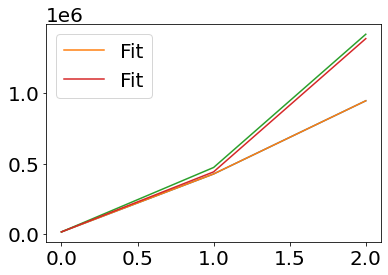

In [ ]:
plt.plot([num_unigrams_features, num_bigrams_only_features, num_trigrams_only_features])
n_bi, n_tri = np.log(num_bigrams_only_features)/np.log(num_unigrams_features), np.log(num_trigrams_only_features)/np.log(num_unigrams_features)
plt.plot([num_unigrams_features, num_unigrams_features**n_bi, num_unigrams_features**n_tri], label='Fit')
plt.plot([num_unigrams_features, num_bigrams_features, num_bigrams_and_trigrams_features])
plt.plot([num_unigrams_features, num_unigrams_features+num_unigrams_features**n_bi, num_unigrams_features+num_unigrams_features**n_bi+num_unigrams_features**n_tri], label='Fit')
plt.legend()
n_bi, n_tri

# SVM

## Question 6 and 6.1

### Word Counts

In [33]:
print("--- classifying reviews using SVM on held-out test set ---")
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=False,tf=False,idf=False)
SVM.train(corpus_txt_token.train)
SVM.test(corpus_txt_token.train)
print(f"Training accuracy with SVM using unigrams: {SVM.getAccuracy():.5f}")
SVM.test(corpus_txt_token.test)
print(f"Test accuracy with SVM using unigrams: {SVM.getAccuracy():.5f}")

--- classifying reviews using SVM on held-out test set ---
Training accuracy with SVM using unigrams: 0.81056
Test accuracy with SVM using unigrams: 0.72000


In [34]:
print("--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---")
SVM.crossValidate(corpus_txt_token,verbose=False)
svm_og_preds=SVM.predictions
print(f"Accuracy: {SVM.getAccuracy():.5f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.5f}")

--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---
Accuracy: 0.74050
Std. Dev: 0.03086


### Term Frequency

In [35]:
print("--- classifying reviews using SVM on held-out test set ---")
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=False,tf=True,idf=False)
SVM.train(corpus_txt_token.train)
SVM.test(corpus_txt_token.train)
print(f"Training accuracy with SVM using unigrams: {SVM.getAccuracy():.5f}")
SVM.test(corpus_txt_token.test)
print(f"Test accuracy with SVM using unigrams: {SVM.getAccuracy():.5f}")

--- classifying reviews using SVM on held-out test set ---
Training accuracy with SVM using unigrams: 0.86611
Test accuracy with SVM using unigrams: 0.79000


In [36]:
print("--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---")
SVM.crossValidate(corpus_txt_token,verbose=False)
svm_tf_preds=SVM.predictions
print(f"Accuracy: {SVM.getAccuracy():.5f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.5f}")

--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---
Accuracy: 0.78700
Std. Dev: 0.02629


In [37]:
# see if using term frequency significantly improves results on words counts
p_value=signTest.getSignificance(svm_og_preds,svm_tf_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using tf {significance} with respect to word counts")

results using tf significant with respect to word counts


### tf-idf

In [122]:
print("--- classifying reviews using SVM on held-out test set ---")
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=False,tf=True,idf=True)
SVM.train(corpus_txt_token.train)
SVM.test(corpus_txt_token.train)
print(f"Training accuracy with SVM using unigrams: {SVM.getAccuracy():.5f}")
SVM.test(corpus_txt_token.test)
print(f"Test accuracy with SVM using unigrams: {SVM.getAccuracy():.5f}")

--- classifying reviews using SVM on held-out test set ---
Training accuracy with SVM using unigrams: 0.99944
Test accuracy with SVM using unigrams: 0.84500


In [123]:
print("--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---")
SVM.crossValidate(corpus_txt_token,verbose=False)
# store predictions from classifier
svm_tf_idf_preds=SVM.predictions
print(f"Accuracy: {SVM.getAccuracy():.5f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.5f}")

--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---
Accuracy: 0.83250
Std. Dev: 0.01365


In [124]:
# see if using tf-idf significantly improves results on words counts
p_value=signTest.getSignificance(svm_og_preds,svm_tf_idf_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using tf-idf {significance} with respect to word counts")

NameError: name 'svm_og_preds' is not defined

In [41]:
# see if using tf-idf significantly improves results on tf
p_value=signTest.getSignificance(svm_tf_preds,svm_tf_idf_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using tf-idf {significance} with respect to tf")

results using tf-idf significant with respect to tf


### Grid Search

In [74]:
svm_gs_params = {
    "C": np.arange(0.2, 10.2, 0.4),
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=False,tf=True,idf=True)
svc_gs = SVM.train(corpus_txt_token.train, grid_search_params=svm_gs_params)

In [75]:
svc_gs.best_params_, svc_gs.best_score_

({'C': 1.8000000000000003, 'kernel': 'linear'}, 0.8616666666666667)

In [76]:
svc_gs.cv_results_

{'mean_fit_time': array([11.7771997 , 11.08415627, 11.4020045 , 11.75602176, 12.91848378,
        12.27352664, 12.30865901, 11.23017778, 13.52083213, 12.95888553,
        12.94150095, 11.62784498, 14.11934679, 12.07865899, 11.96514297,
        11.15873659, 12.80318   , 12.19422295, 12.50772538, 11.65334778,
        13.31823916, 12.05407724, 12.20407643, 11.80693839, 13.05565815,
        12.45732954, 12.45252907, 11.34348392, 12.43181229, 11.35014892,
        11.47078567, 10.93652701, 12.34006765, 11.42055669, 11.6821362 ,
        11.19219208, 13.28793738, 11.9431767 , 11.69839456, 11.86353006,
        14.00135782, 12.70679996, 13.18643205, 13.02119262, 14.32865858,
        12.81467886, 12.83205504, 12.14688842, 13.00670867, 11.8580739 ,
        11.80710359, 11.42570257, 13.02858386, 12.04253633, 12.30937822,
        11.78805025, 13.38467166, 12.46113043, 13.57320368, 13.89251554,
        13.68228576, 12.05583191, 11.997824  , 11.36676309, 13.00660901,
        12.89301715, 12.52354484, 

In [118]:
print("--- classifying reviews using SVM on held-out test set ---")
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=False,tf=True,idf=True,C=1.8,kernel='linear')
SVM.train(corpus_txt_token.train)
SVM.test(corpus_txt_token.train)
print(f"Training accuracy with SVM using unigrams: {SVM.getAccuracy():.5f}")
SVM.test(corpus_txt_token.test)
print(f"Test accuracy with SVM using unigrams: {SVM.getAccuracy():.5f}")

--- classifying reviews using SVM on held-out test set ---
Training accuracy with SVM using unigrams: 0.99944
Test accuracy with SVM using unigrams: 0.89000


In [119]:
print("--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---")
SVM.crossValidate(corpus_txt_token,verbose=False)
# store predictions from classifier
svm_tf_idf_opt_preds=SVM.predictions
print(f"Accuracy: {SVM.getAccuracy():.5f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.5f}")

--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---
Accuracy: 0.86100
Std. Dev: 0.01997


In [125]:
# see if using optimised hyperameters significantly improves default results
p_value=signTest.getSignificance(svm_tf_idf_preds, svm_tf_idf_opt_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using optimised SVC hyperparameters {significance} with respect to defaults")

results using optimised SVC hyperparameters not significant with respect to defaults


In [121]:
# see if SVM significantly improves results on smoothed NB
p_value=signTest.getSignificance(nb_smoothed_txt_token_preds,svm_tf_idf_opt_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using SVM {significance} with respect to smoothed NB")

results using SVM not significant with respect to smoothed NB


### Bigrams

In [127]:
# SVM=SVMText(bigrams=True,trigrams=False,discard_closed_class=False,tf=True,idf=True,C=1.8,kernel='linear')
SVM=SVMText(bigrams=True,trigrams=False,discard_closed_class=False,tf=True,idf=True)
SVM.train(corpus_txt_token.train)
SVM.test(corpus_txt_token.train)
print(f"Training accuracy with SVM using additional bigrams: {SVM.getAccuracy():.5f}")
SVM.test(corpus_txt_token.test)
print(f"Test accuracy with SVM using additional bigrams: {SVM.getAccuracy():.5f}")

Training accuracy with SVM using additional bigrams: 1.00000
Test accuracy with SVM using additional bigrams: 0.86000


In [128]:
print("--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---")
SVM.crossValidate(corpus_txt_token,verbose=False)
print(f"Accuracy: {SVM.getAccuracy():.5f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.5f}")

--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---
Accuracy: 0.84450
Std. Dev: 0.02115


### Trigrams

In [129]:
# SVM=SVMText(bigrams=True,trigrams=True,discard_closed_class=False,tf=True,idf=True,C=1.8,kernel='linear')
SVM=SVMText(bigrams=True,trigrams=True,discard_closed_class=False,tf=True,idf=True)
SVM.train(corpus_txt_token.train)
SVM.test(corpus_txt_token.train)
print(f"Training accuracy with SVM using additional bigrams and trigrams: {SVM.getAccuracy():.5f}")
SVM.test(corpus_txt_token.test)
print(f"Teat accuracy with SVM using additional bigrams and trigrams: {SVM.getAccuracy():.5f}")

Training accuracy with SVM using additional bigrams and trigrams: 1.00000
Teat accuracy with SVM using additional bigrams and trigrams: 0.84000


In [130]:
print("--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---")
SVM.crossValidate(corpus_txt_token,verbose=False)
print(f"Accuracy: {SVM.getAccuracy():.5f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.5f}")

--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---
Accuracy: 0.84750
Std. Dev: 0.02228


# POS

## Question 7

In [131]:
print("--- adding in POS information to corpus ---")

--- adding in POS information to corpus ---


In [132]:
# print("--- pos corpus ---")
# # retrieve corpus with tokenized text and pos
# pos_corpus_pickle = "corpus_pos.pkl"
# if use_pickles and os.path.isfile(pos_corpus_pickle):
#     with open(pos_corpus_pickle, 'rb') as f:
#         pos_corpus = pickle.load(f)
# else:
#     pos_corpus=MovieReviewCorpus(pos=True)
#     with open(pos_corpus_pickle, 'wb') as f:
#         pickle.dump(pos_corpus, f)

In [133]:
# pos_corpus=MovieReviewCorpus(pos=True)
corpus_tag_pos=MovieReviewCorpus(pos=True,stemming=False)

Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [134]:
print("--- training nb on word+pos features ----")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_tag_pos.train)
NB.test(corpus_tag_pos.test, verbose=False)
print(f"Accuracy using NB on unigrams without smoothing and with POS: {NB.getAccuracy():.5f}")

--- training nb on word+pos features ----


/Users/alanclark/git/MLMI13/Classifiers.py:248: RuntimeWarning: divide by zero encountered in log
  log_word_prob = np.log(word_prob)


Accuracy using NB on unigrams without smoothing and with POS: 0.46500


In [135]:
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_tag_pos.train)
NB.test(corpus_tag_pos.test, verbose=False)
print(f"Accuracy using NB on unigrams with smoothing and POS: {NB.getAccuracy():.5f}")

Accuracy using NB on unigrams with smoothing and POS: 0.83000


In [136]:
print("--- training svm on word+pos features ----")
# SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=False,tf=True,idf=True,C=1.8,kernel='linear')
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=False,tf=True,idf=True)
SVM.train(corpus_tag_pos.train)
SVM.test(corpus_tag_pos.train)
print(f"Training accuracy with SVM with POS: {SVM.getAccuracy():.5f}")
SVM.test(corpus_tag_pos.test)
print(f"Test accuracy with SVM with POS: {SVM.getAccuracy():.5f}")

--- training svm on word+pos features ----
Training accuracy with SVM with POS: 1.00000
Test accuracy with SVM with POS: 0.84500


In [137]:
print("--- classifying reviews using svm on word+pos and 10-fold cross-eval ---")
SVM.crossValidate(corpus_tag_pos)
# store predictions from classifier
svm_pos_preds=SVM.predictions
print(f"Accuracy: {SVM.getAccuracy():.5f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.5f}")

--- classifying reviews using svm on word+pos and 10-fold cross-eval ---
Accuracy: 0.83650
Std. Dev: 0.01305


In [138]:
# see if POS significantly improves results on SVM only
p_value=signTest.getSignificance(svm_tf_idf_preds,svm_pos_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using POS tags {significance} with respect to SVM")

results using POS tags not significant with respect to SVM


# Discard Closed Class

In [142]:
print("--- training nb discarding closed-class words ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=True)
NB.train(corpus_tag_pos.train)
NB.test(corpus_tag_pos.train, verbose=False)
print(f"Training accuracy using NB without smoothing and discarding closed-class words: {NB.getAccuracy():.5f}")
NB.test(corpus_tag_pos.test, verbose=False)
print(f"Test accuracy using NB without smoothing and discarding closed-class words: {NB.getAccuracy():.5f}")

--- training nb discarding closed-class words ---


/Users/alanclark/git/MLMI13/Classifiers.py:248: RuntimeWarning: divide by zero encountered in log
  log_word_prob = np.log(word_prob)


Training accuracy using NB without smoothing and discarding closed-class words: 1.00000
Test accuracy using NB without smoothing and discarding closed-class words: 0.46500


In [143]:
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=True)
NB.train(corpus_tag_pos.train)
NB.test(corpus_tag_pos.train, verbose=False)
print(f"Training accuracy using NB with smoothing and discarding closed-class words: {NB.getAccuracy():.5f}")
NB.test(corpus_tag_pos.test, verbose=False)
print(f"Test accuracy using NB with smoothing and discarding closed-class words: {NB.getAccuracy():.5f}")

Training accuracy using NB with smoothing and discarding closed-class words: 0.98667
Test accuracy using NB with smoothing and discarding closed-class words: 0.83000


In [144]:
print("--- training svm discarding closed-class words ---")
# SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=True,C=1.8,kernel='linear')
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=True)
SVM.train(corpus_tag_pos.train)
SVM.test(corpus_tag_pos.train)
print(f"Training accuracy with SVM discarding closed-class word: {SVM.getAccuracy():.5f}")
SVM.test(corpus_tag_pos.test)
print(f"Test accuracy with SVM discarding closed-class word: {SVM.getAccuracy():.5f}")

--- training svm discarding closed-class words ---
Training accuracy with SVM discarding closed-class word: 0.97056
Test accuracy with SVM discarding closed-class word: 0.84000


In [145]:
print("--- classifying reviews using svm discarding closed-class words and 10-fold cross-eval ---")
SVM.crossValidate(corpus_tag_pos)
# store predictions from classifier
svm_closed_class=SVM.predictions
print(f"Accuracy: {SVM.getAccuracy():.5f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.5f}")

--- classifying reviews using svm discarding closed-class words and 10-fold cross-eval ---
Accuracy: 0.81100
Std. Dev: 0.02634


In [146]:
# see if discarding closed-class words significantly improves results on SVM only
p_value=signTest.getSignificance(svm_tf_idf_preds,svm_closed_class)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results discardig closed-class words {significance} with respect to SVM")

results discardig closed-class words not significant with respect to SVM


## Question 8.0

In [ ]:
# print("--- using document embeddings ---")